### Qn 1

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision import models


In [2]:
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [3]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 10)
model = model.to(device)


In [5]:
from torchinfo import summary

summary(
    model,
    input_size=(1, 3, 224, 224),
    device="cuda" 
)


Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 1024, 7, 7]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
│    └─_DenseBlock: 2-5                  [1, 256, 56, 56]          --
│    │    └─_DenseLayer: 3-1             [1, 32, 56, 56]           45,440
│    │    └─_DenseLayer: 3-2             [1, 32, 56, 56]           49,600
│    │    └─_DenseLayer: 3-3             [1, 32, 56, 56]           53,760
│    │    └─_DenseLayer: 3-4             [1, 32, 56, 56]           57,920
│    │    └─_DenseLayer: 3-5             [1, 32, 56, 56]           62,080
│    │    └─_DenseLayer: 3-6             [1, 32, 56, 56]     

In [6]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [7]:
for param in model.features.parameters():
    param.requires_grad = False


In [8]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.classifier.parameters(), lr=1e-3
)


In [9]:
for epoch in range(5):
    model.train()
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/5], Loss: {running_loss/len(trainloader):.4f}")


Epoch [1/5], Loss: 0.9912
Epoch [2/5], Loss: 0.7456
Epoch [3/5], Loss: 0.7055
Epoch [4/5], Loss: 0.6942
Epoch [5/5], Loss: 0.6780


In [10]:
model.eval()
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)              
        _, predicted = torch.max(outputs, 1) 
        all_preds.append(predicted.cpu())
        all_labels.append(labels.cpu())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 81.12%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

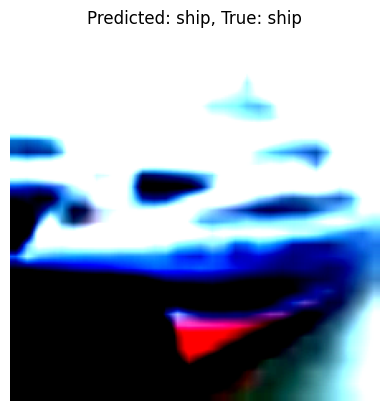

In [11]:
from PIL import Image
import matplotlib.pyplot as plt

img, label = testset[1]
model.eval()

with torch.no_grad():
    img_input = img.unsqueeze(0).to(device)  
    output = model(img_input)
    pred = output.argmax(dim=1).item()
    
classes = testset.classes

plt.imshow(img.permute(1, 2, 0))
plt.title(f"Predicted: {classes[pred]}, True: {classes[label]}")
plt.axis("off")


(10, 10)


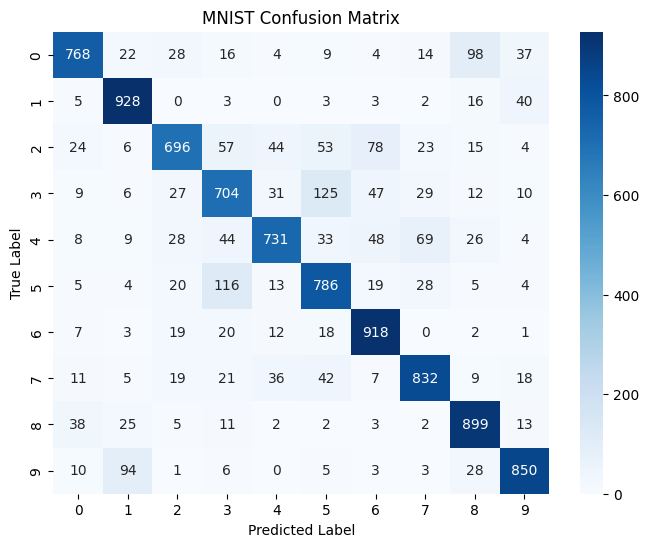

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
print(cm.shape)   # (10, 10)


plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=range(10),
    yticklabels=range(10)
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("MNIST Confusion Matrix")
plt.show()


### QN 2


In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),          # converts to [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean & std
])

trainset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4)


In [14]:
class Model(nn.Module):
    def __init__(self ):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = Model().to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=1e-3)


In [17]:
for epoch in range(20):
    model2.train()
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/20], Loss: {running_loss/len(trainloader):.4f}")

Epoch [1/20], Loss: 0.2775
Epoch [2/20], Loss: 0.1159
Epoch [3/20], Loss: 0.0813
Epoch [4/20], Loss: 0.0665
Epoch [5/20], Loss: 0.0490
Epoch [6/20], Loss: 0.0435
Epoch [7/20], Loss: 0.0349
Epoch [8/20], Loss: 0.0301
Epoch [9/20], Loss: 0.0251
Epoch [10/20], Loss: 0.0232
Epoch [11/20], Loss: 0.0221
Epoch [12/20], Loss: 0.0198
Epoch [13/20], Loss: 0.0170
Epoch [14/20], Loss: 0.0167
Epoch [15/20], Loss: 0.0147
Epoch [16/20], Loss: 0.0162
Epoch [17/20], Loss: 0.0149
Epoch [18/20], Loss: 0.0156
Epoch [19/20], Loss: 0.0116
Epoch [20/20], Loss: 0.0150


In [18]:
model2.eval()
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model2(images)              
        _, predicted = torch.max(outputs, 1) 

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.append(predicted.cpu())
        all_labels.append(labels.cpu())
accuracy = 100 * correct / total
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 97.83%


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

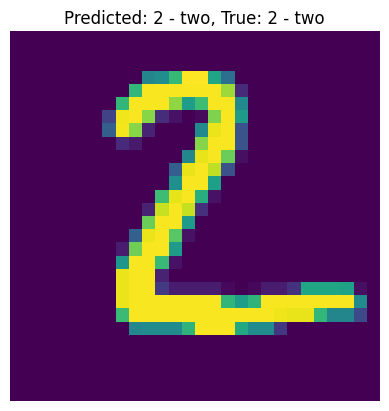

In [19]:
from PIL import Image
import matplotlib.pyplot as plt

img, label = testset[1]
model2.eval()

with torch.no_grad():
    img_input = img.unsqueeze(0).to(device)  
    output = model2(img_input)
    pred = output.argmax(dim=1).item()
    
classes = testset.classes

plt.imshow(img.permute(1, 2, 0))
plt.title(f"Predicted: {classes[pred]}, True: {classes[label]}")
plt.axis("off")


In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
print(cm.shape)   # (10, 10)


(10, 10)


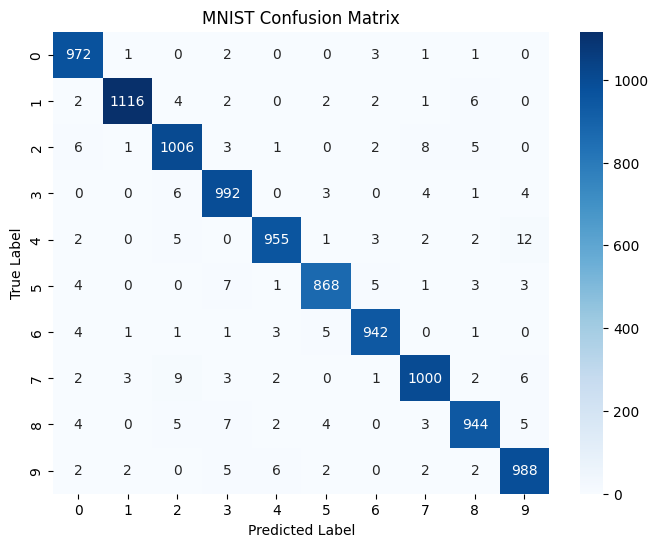

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=range(10),
    yticklabels=range(10)
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("MNIST Confusion Matrix")
plt.show()
